# Project 4 - Question 1
### Predicting whether a job fetches low or high salary (>= $6750)

In [1]:
import pickle
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, precision_score

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
plt.style.use('seaborn')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
jobs_df = pd.read_pickle('./Data/jobs_df.pkl')
jobs_df.head(3)

,job_id,high_salary,communication_requirements,sql_requirements,python_requirements,analytical_requirements,analytics_requirements,hadoop_requirements,apache_requirements,visualization_requirements,...,entry_level,executive_level,fresh_level,junior_level,management_level,manager_level,middle_level,non_level,professional_level,senior_level
0,JOB-2019-0059399,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,JOB-2019-0088262,1,1,0,0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,JOB-2019-0088339,1,1,0,1,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1


## Baseline

In [3]:
# baseline accuracy = 51%
baseline = 1 - jobs_df['high_salary'].mean()
baseline

0.5123873873873874

In [4]:
y = jobs_df['high_salary'].values
X = jobs_df.drop(columns=['high_salary', 'job_id'])

## Train Test Split

In [5]:
# traintestsplit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=50)
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('X_test:', y_test.shape)

X_train: (754, 82)
y_train: (754,)
X_test: (134, 82)
X_test: (134,)


## Scale

In [6]:
ss = StandardScaler()
# Xs_train = ss.fit_transform(X_train)
# Xs_test = ss.fit_transform(X_test)

Xs_train = pd.DataFrame(ss.fit_transform(X_train), columns = X_train.columns)
Xs_test = pd.DataFrame(ss.fit_transform(X_test), columns = X_test.columns)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


# MODELLING
## Logistic Regression

In [7]:
logreg = LogisticRegression()

cv_score = cross_val_score(logreg, Xs_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
print('Vanilla Log Reg 5-Fold CV ROC-AUC Scores:\n', cv_score)
print('Vanilla Log Reg Avg ROC_AUC Score:\n', cv_score.mean())

# Log Reg 5-Fold CV ROC-AUC Scores:
#  [0.77676715 0.71340821 0.77746578 0.7698808  0.7968333 ]
# Log Reg Avg ROC_AUC Score:
#  0.7668710500902283

Vanilla Log Reg 5-Fold CV ROC-AUC Scores:
 [0.77676715 0.71340821 0.77746578 0.7698808  0.7968333 ]
Vanilla Log Reg Avg ROC_AUC Score:
 0.7668710500902283


In [8]:
# auc on test set
logreg.fit(Xs_train, y_train)

logreg_testset_auc = roc_auc_score(y_test, logreg.predict_proba(Xs_test)[:,1])

print('Vanilla Log Reg AUC Score on Test Set:\n', logreg_testset_auc)

# Log Reg AUC Score on Test Set:
#  0.8041248606465998

Vanilla Log Reg AUC Score on Test Set:
 0.8041248606465998


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


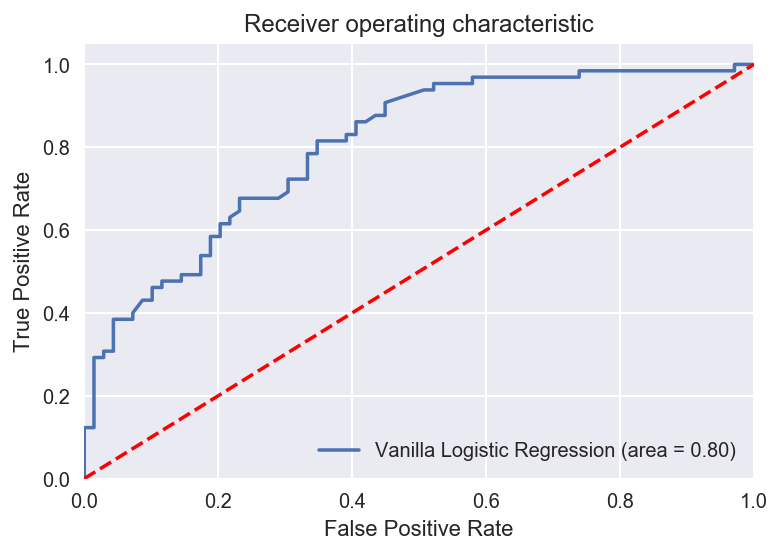

In [9]:
# logit_roc_auc = roc_auc_score(y_test, logreg.predict_proba(Xs_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(Xs_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Vanilla Logistic Regression (area = %0.2f)' % logreg_testset_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Perform grid search to try optimise the vanilla logistic regression model

In [10]:
# conduct gridsearch on logistic regression to see if there is improvement

params = dict(C=np.linspace(0.0001, 1), penalty=['l2'])

grid = GridSearchCV(logreg, param_grid=params, cv=5, n_jobs=-1).fit(Xs_train, y_train)

print('Best Params:', grid.best_params_)

Best Params: {'C': 0.02050612244897959, 'penalty': 'l2'}


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [11]:
logreg_gs = LogisticRegression(C=0.02050612244897959, penalty='l2')

cv_score = cross_val_score(logreg_gs, Xs_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)

print('GS Log Reg 5-Fold CV ROC-AUC Scores:\n', cv_score)
print('GS Log Reg Avg ROC_AUC Score:\n', cv_score.mean())

# GS Log Reg 5-Fold CV ROC-AUC Scores:
#  [0.7748614  0.71604072 0.79484029 0.78073297 0.81159936]
# GS Log Reg Avg ROC_AUC Score:
#  0.7756149471902896

GS Log Reg 5-Fold CV ROC-AUC Scores:
 [0.7748614  0.71604072 0.79484029 0.78073297 0.81159936]
GS Log Reg Avg ROC_AUC Score:
 0.7756149471902896


In [12]:
# auc on test set
logreg_gs.fit(Xs_train, y_train)

logreg_testset_auc = roc_auc_score(y_test, logreg_gs.predict_proba(Xs_test)[:,1])
logreg_testset_auc

# 0.8076923076923078

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8076923076923078

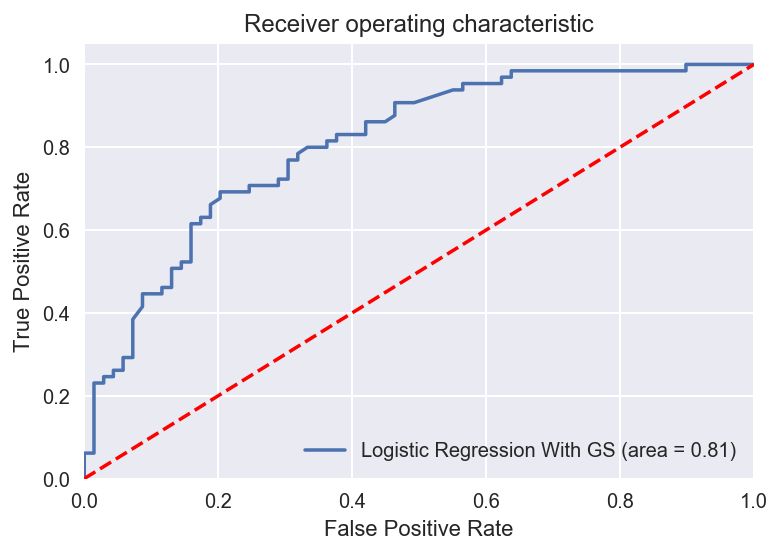

In [13]:
# logit_roc_auc = roc_auc_score(y_test, logreg.predict_proba(Xs_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, logreg_gs.predict_proba(Xs_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression With GS (area = %0.2f)' % logreg_testset_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## AUC of Logistic Regression With GridSearch:
- train set: 0.776
- test set: 0.808

# Bernoulli Naive Bayes using pre-scaled binary features

In [14]:
bnb = BernoulliNB()

cv_score = cross_val_score(bnb, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)

print('Bernoulli NB 5-Fold CV ROC-AUC Scores:\n', cv_score)
print('Bernoulli NB Avg ROC_AUC Score:\n', cv_score.mean())

# Bernoulli NB 5-Fold CV ROC-AUC Scores:
#  [0.75476438 0.7042822  0.80870481 0.78713752 0.82316314]
# Bernoulli NB Avg ROC_AUC Score:
#  0.7756104101994513

Bernoulli NB 5-Fold CV ROC-AUC Scores:
 [0.75476438 0.7042822  0.80870481 0.78713752 0.82316314]
Bernoulli NB Avg ROC_AUC Score:
 0.7756104101994513


In [15]:
# auc on test set
bnb.fit(X_train, y_train)
bnb_testset_auc = roc_auc_score(y_test, bnb.predict_proba(X_test)[:,1])

print('Bernoilli NB testset auc:\n', bnb_testset_auc)

# Bernoilli NB testset auc:
#  0.7898550724637682

Bernoilli NB testset auc:
 0.7898550724637682


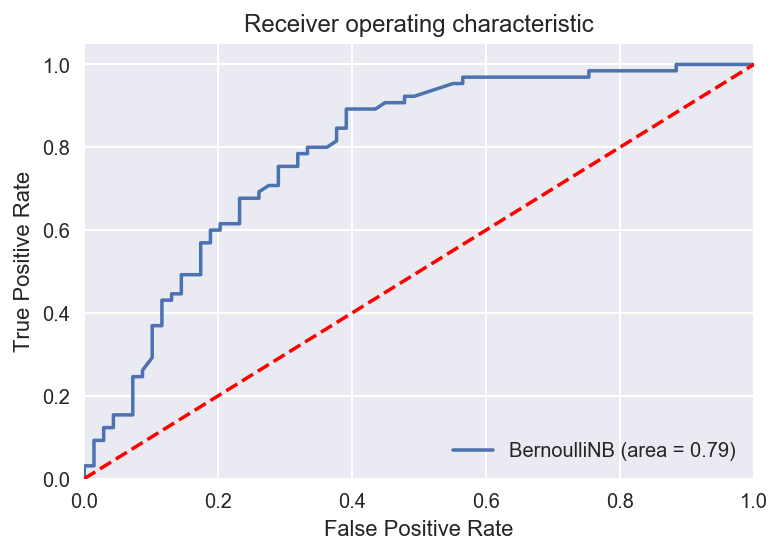

In [16]:
fpr, tpr, thresholds = roc_curve(y_test, bnb.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='BernoulliNB (area = %0.2f)' % bnb_testset_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# RandomForestClassifier
- commented out this section to prevent it to re-run everytime i restart and run kernel

In [17]:
rfc = RandomForestClassifier()

cv_score = cross_val_score(rfc, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)

print('RandomForestClassifier 5-Fold CV Score:\n', cv_score)
print('RandomForestClassifier AVG CV Score:\n', cv_score.mean())

# RandomForestClassifier 5-Fold CV Score:
#  [0.78031878 0.74482274 0.78518779 0.76089664 0.75217933]
# RandomForestClassifier AVG CV Score:
#  0.7646810550920139

RandomForestClassifier 5-Fold CV Score:
 [0.75121275 0.72937873 0.76983152 0.76507739 0.74942181]
RandomForestClassifier AVG CV Score:
 0.7529844399707413


In [18]:
# auc on test set
rfc.fit(X_train, y_train)

rfc_testset_auc = roc_auc_score(y_test, rfc.predict_proba(X_test)[:,1])

print('RandomForestClassifier testset auc:\n', rfc_testset_auc)

# RandomForestClassifier testset auc:
#  0.7738015607580826

RandomForestClassifier testset auc:
 0.7816053511705686


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


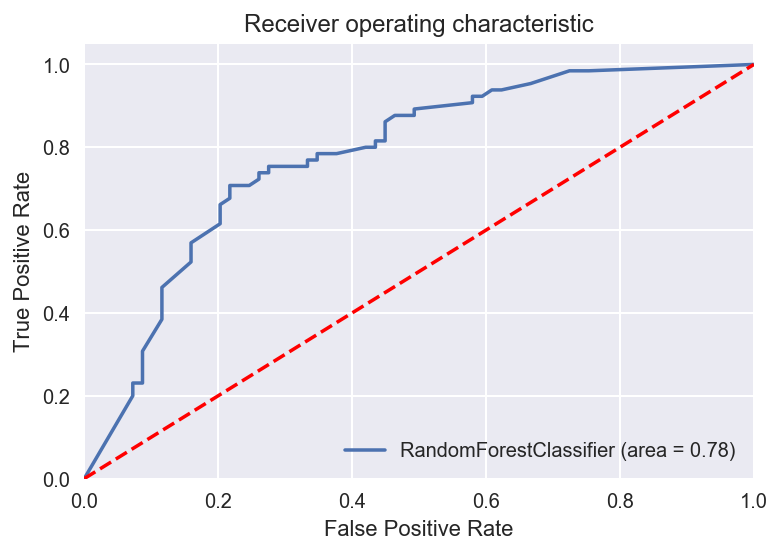

In [19]:
fpr, tpr, thresholds = roc_curve(y_test, rfc.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='RandomForestClassifier (area = %0.2f)' % rfc_testset_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# GridSearch on RandomForestClassifier
- commented out this section to prevent it to re-run everytime i restart and run kernel

In [20]:
# param_grid = {'n_estimators': np.arange(10,500),
#               'max_features': ['auto', 'sqrt', 'log2'],
#               'max_depth': [5, 10, 15, 20]}

# CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5, n_jobs=-1).fit(X_train, y_train)
# CV_rfc.best_params_

# # {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 50}

In [21]:
# rfc = RandomForestClassifier(max_depth=10, max_features='sqrt', n_estimators=10)

# cv_score = cross_val_score(rfc, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
# print('RandomForestClassifier GS 5-Fold CV AUCs:\n', cv_score)
# print('RandomForestClassifier GS AVG AUC:\n', cv_score.mean())

# # RandomForestClassifier GS 5-Fold CV AUCs:
# #  [0.80933818 0.75061425 0.78501229 0.7778865  0.78482476]
# # RandomForestClassifier GS AVG AUC:
# #  0.7815351962612237

In [22]:
# # auc on test set
# rfc.fit(X_train, y_train)

# rfc_gs_testset_auc = roc_auc_score(y_test, rfc.predict_proba(X_test)[:,1])

# print('RandomForestClassifier with GS testset auc:\n', rfc_gs_testset_auc)

# # RandomForestClassifier with GS testset auc:
# #  0.8052396878483835

In [23]:
# fpr, tpr, thresholds = roc_curve(y_test, rfc.predict_proba(X_test)[:,1])
# plt.figure()
# plt.plot(fpr, tpr, label='RandomForestClassifier With GS (area = %0.2f)' % rfc_gs_testset_auc)
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
# plt.legend(loc="lower right")
# plt.show()

# Final Model of Choice = Logistic Regression With L1 Penalty
- RandomForestClassifier with best parameters & Benoulli Naive Bayes gave pretty decent AUCs but LogisticRegression is prefered due to its computational speed

In [24]:
logreg = LogisticRegression(C=0.02050612244897959, penalty='l2')

cv_score = cross_val_score(logreg, Xs_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
print('GS Log Reg 5-Fold CV ROC-AUC Scores:\n', cv_score)
print('GS Log Reg Avg ROC_AUC Score:\n', cv_score.mean())

GS Log Reg 5-Fold CV ROC-AUC Scores:
 [0.7748614  0.71604072 0.79484029 0.78073297 0.81159936]
GS Log Reg Avg ROC_AUC Score:
 0.7756149471902896


In [25]:
# auc on test set
logreg.fit(Xs_train, y_train)

roc_auc_score(y_test, logreg.predict_proba(Xs_test)[:,1])

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8076923076923078

### Classification Report:

In [26]:
y_pred = logreg.predict(Xs_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.70      0.73        69
           1       0.70      0.77      0.74        65

   micro avg       0.73      0.73      0.73       134
   macro avg       0.73      0.73      0.73       134
weighted avg       0.73      0.73      0.73       134



### Confusion Matrix:

In [27]:
conmat = np.array(confusion_matrix(y_test, y_pred, labels=[1,0]))

In [28]:
confusion_matrix = pd.DataFrame(conmat, index=['actual_high_salary', 'actual_low_salary'],
                         columns=['predicted_high_salary','predicted_low_salary'])
confusion_matrix

,predicted_high_salary,predicted_low_salary
actual_high_salary,50,15
actual_low_salary,21,48


## Analysing the decision threshold as we attempt to reduce false positives. In other words, we optimise precision to avoid situation where client receives a low salary despite being advised that its a high salary job
- increasing the decision threshold to ~0.8/0.9 risks the possibility of reducing accuracy in predicting TPs and TNs as well (can be observed from ROC_AUC curve as well). Perhaps it is better to lower the threshold of $6750 to prevent giving clients false hopes of high salary

In [29]:
y_pred_prob = logreg.predict_proba(Xs_test)

pp = pd.DataFrame(y_pred_prob, columns=['prob_low_salary','prob_high_salary'])
pp.head()

,prob_low_salary,prob_high_salary
0,0.483027,0.516973
1,0.936582,0.063418
2,0.719204,0.280796
3,0.246448,0.753552
4,0.390396,0.609604


In [30]:
for thresh in np.arange(0,1,0.1):
    labeled_high_salary = np.array([1 if x >= thresh else 0 for x in pp['prob_high_salary'].values])
    print('Threshold: {} - false positives: {}'.format(thresh, np.sum((y_test == 0) & (labeled_high_salary == 1))))

Threshold: 0.0 - false positives: 69
Threshold: 0.1 - false positives: 62
Threshold: 0.2 - false positives: 52
Threshold: 0.30000000000000004 - false positives: 39
Threshold: 0.4 - false positives: 27
Threshold: 0.5 - false positives: 21
Threshold: 0.6000000000000001 - false positives: 11
Threshold: 0.7000000000000001 - false positives: 5
Threshold: 0.8 - false positives: 1
Threshold: 0.9 - false positives: 0


In [31]:
# pp['predicted_high_salary'] = [1 if x >= 0.9 else 0 for x in pp['prob_high_salary'].values]
# pp.head()

In [32]:
# # concat y_test and see confusion matrix
# conmat = np.array(confusion_matrix(y_test, y_pred, labels=[1,0]))

# confusion_matrix = pd.DataFrame(conmat, index=['actual_high_salary', 'actual_low_salary'],
#                          columns=['predicted_high_salary','predicted_low_salary'])
# confusion_matrix

## Features that are most influential on high_salary?
- Seniority levels are most influential (would be interesting to see no. of years of experience but data is incomplete)
- Being skilled in machine learning, hadoop, apache, matlab, scala and visualisation are very important
- Jobs in banking and finance could potentially fetch higher salaries as compared to other industries
- Holding a masters degree is important but having a phd is not as important as we think

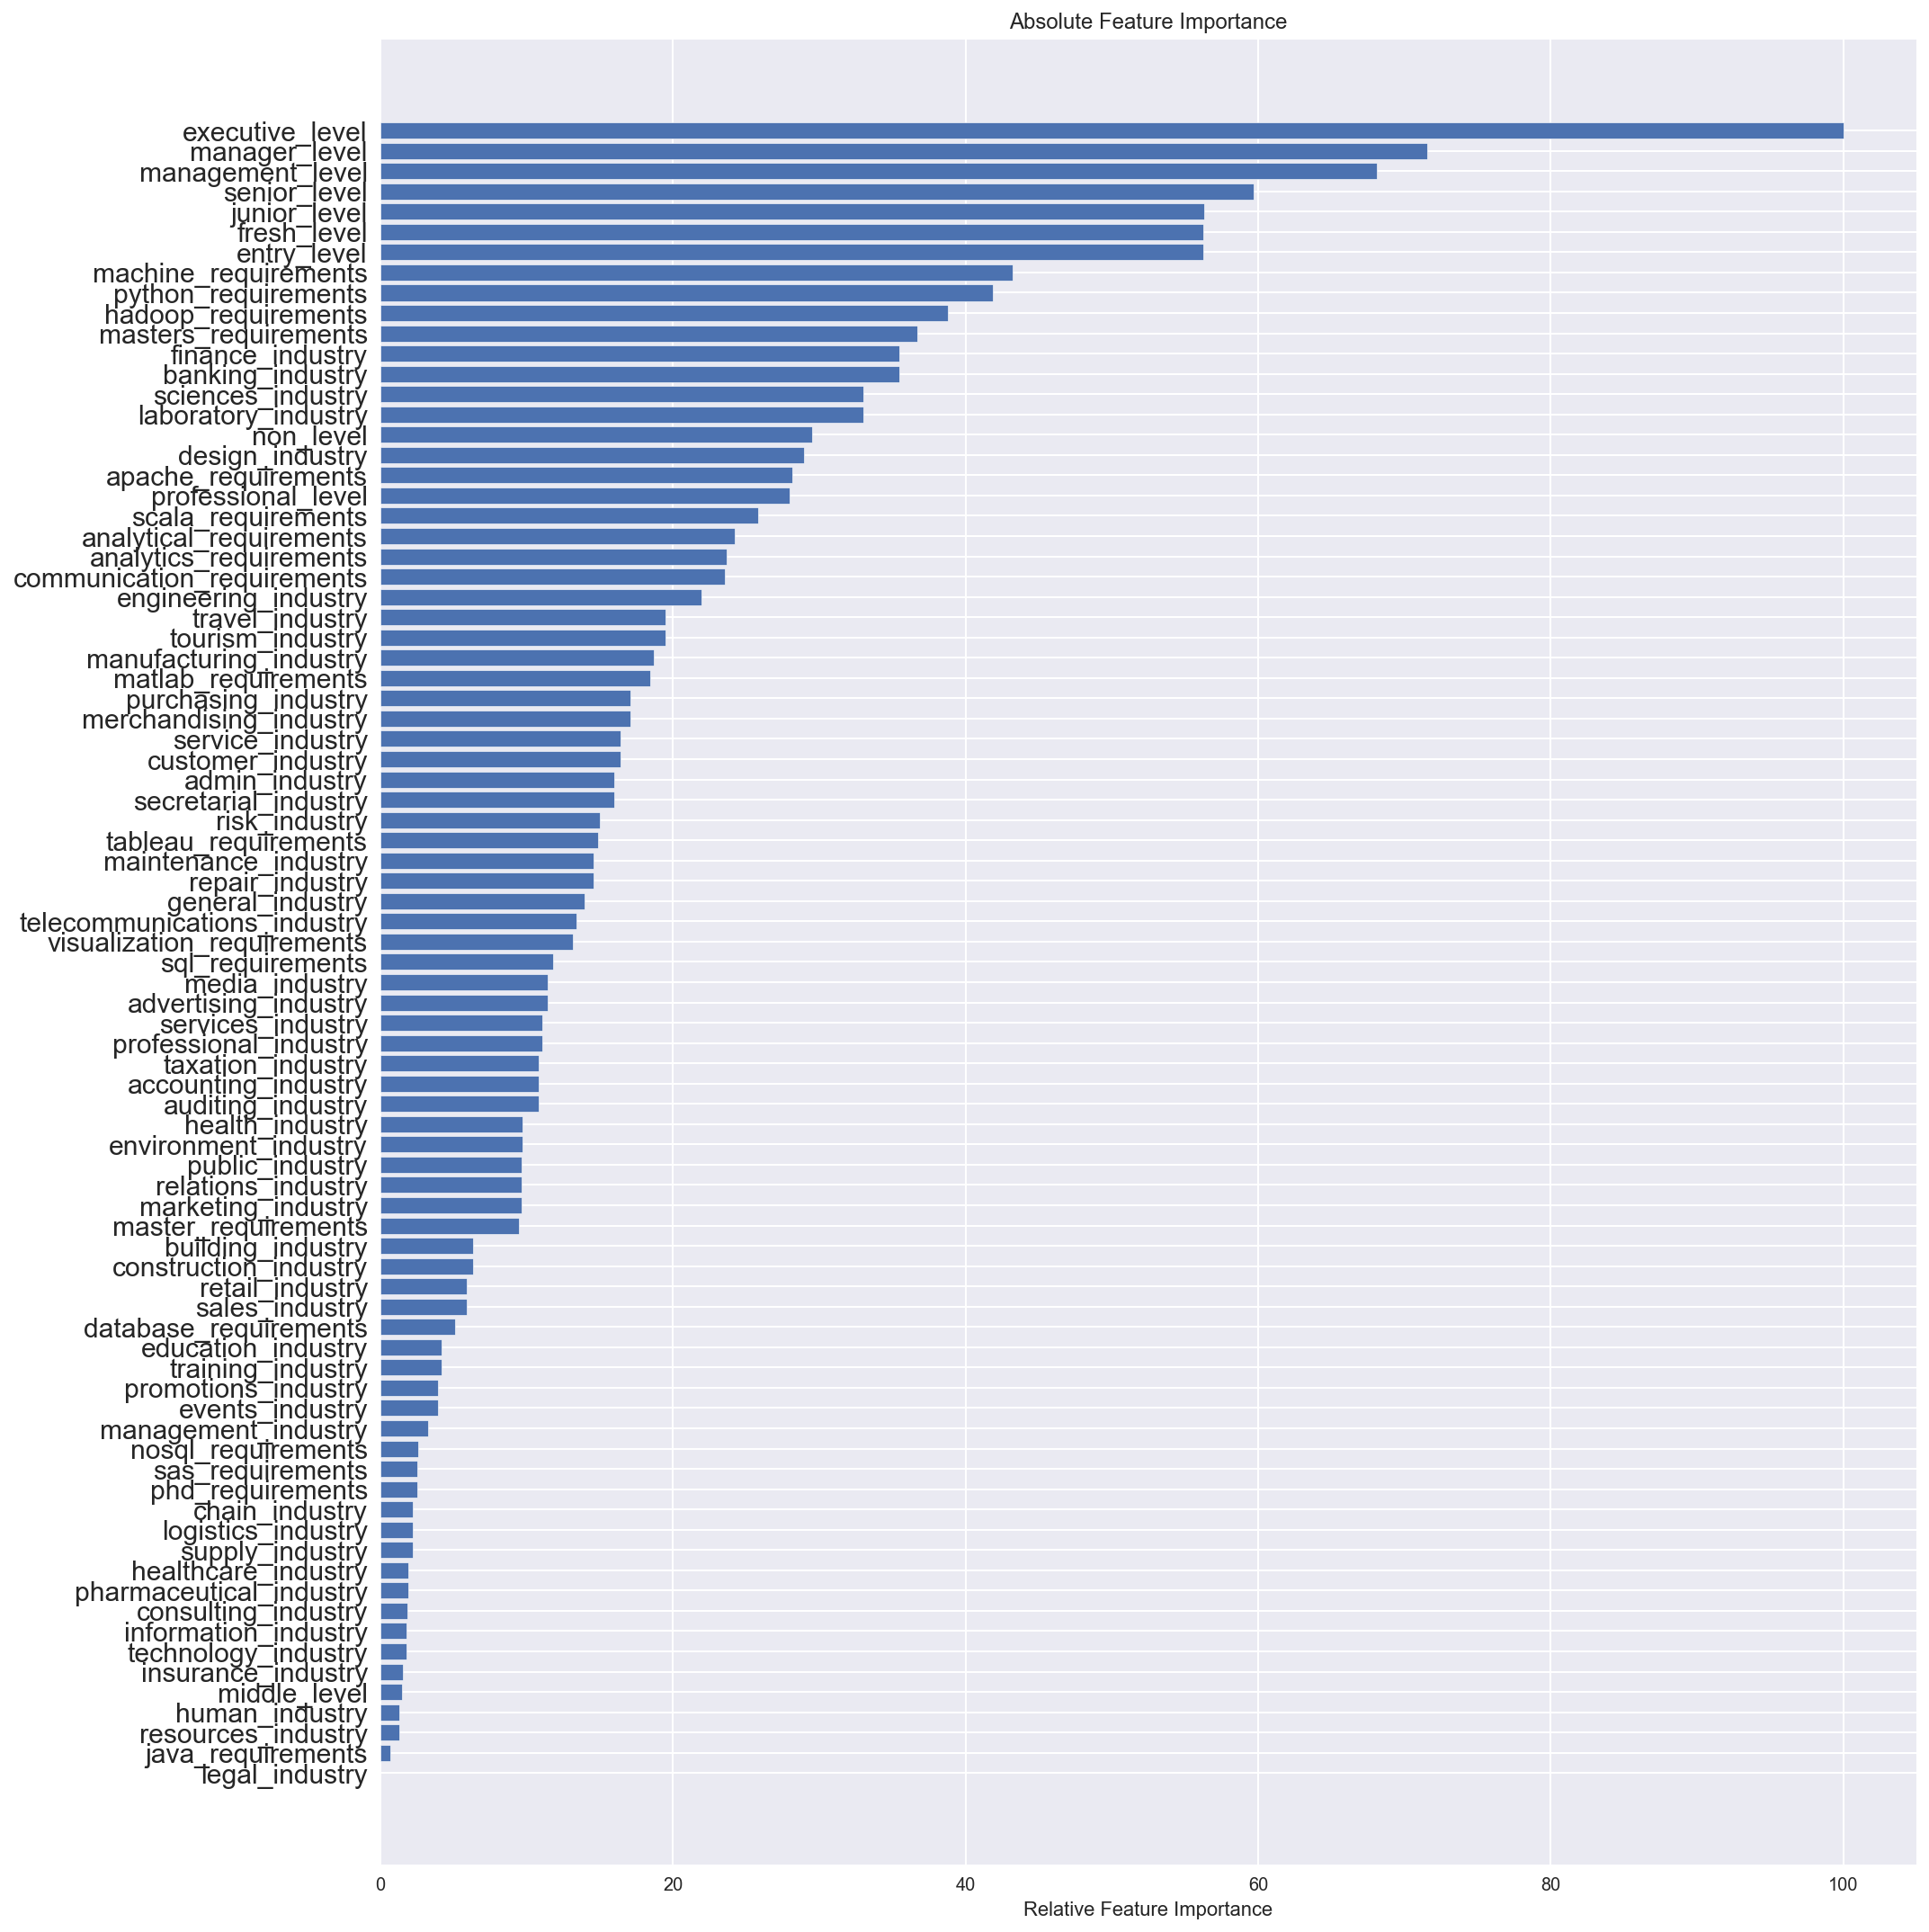

In [33]:
feature_importance = abs(logreg.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(15,15))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(Xs_train.columns)[sorted_idx], fontsize=15)
featax.set_xlabel('Relative Feature Importance')
plt.title('Absolute Feature Importance')
plt.tight_layout()   
plt.show()

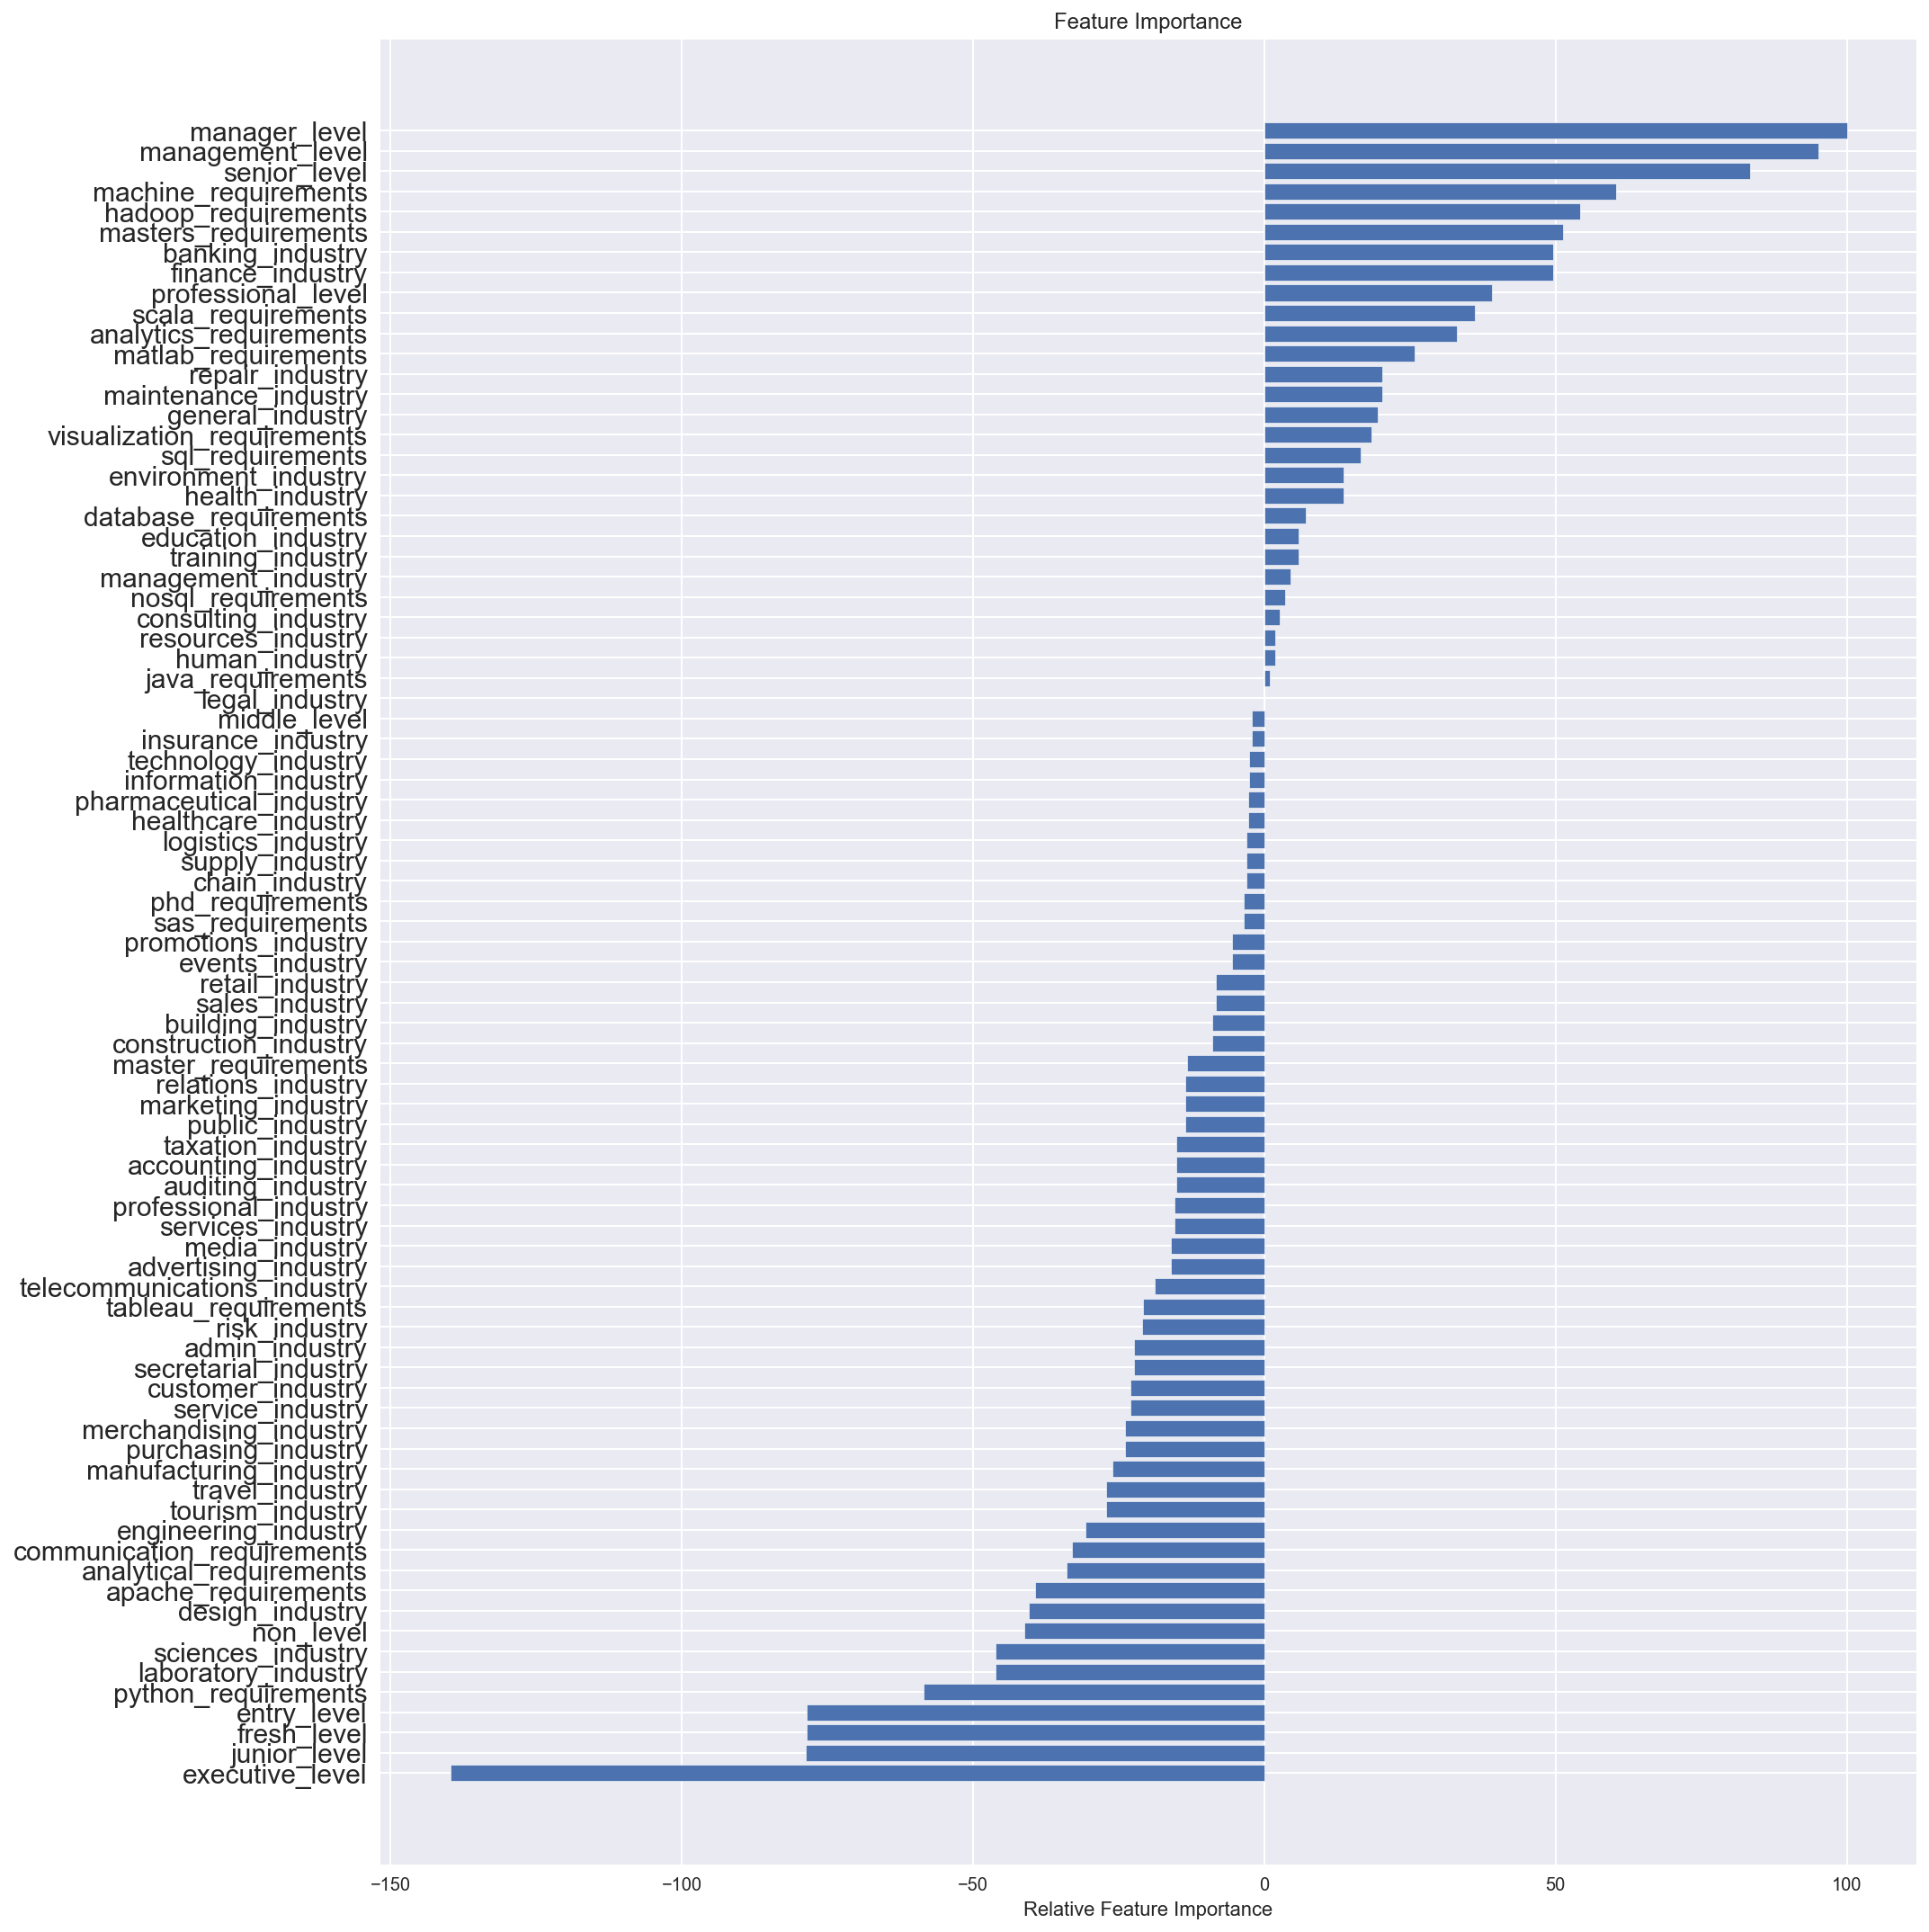

In [34]:
feature_importance = logreg.coef_[0]
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(15,15))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(Xs_train.columns)[sorted_idx], fontsize=15)
featax.set_xlabel('Relative Feature Importance')
plt.title('Feature Importance')
plt.tight_layout()   
plt.show()

In [35]:
# cols = list(X_train.columns)

# coefficients = pd.DataFrame([cols, list(logreg.coef_)], 
#                      index=['feature','logreg_coef']).T.sort_values('logreg_coef', ascending=False)
# coefficients